In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import gzip

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split

from utils import effectiveDimension, factorize, gram, hiddenTargets

/Users/kristjanjonsson/Development/Notebooks/venv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## MNIST dataset

In [61]:
def parse_img(filename):
    '''Parses mnist images in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=16)
    f.close()
    return arr.reshape((-1, 28*28))

def parse_label(filename):
    '''Parses mnist labels in filename.'''
    f = gzip.open(filename)
    arr = np.frombuffer(f.read(), dtype=np.dtype('>u1'), offset=8)
    f.close()
    return arr

def parseNoisyExamples(filename):
    with open(filename) as f:
        arr = np.loadtxt(filename, dtype=np.float32)
        imgs = arr[:,:28*28]
        labels = arr[:,28*28]
        labels = labels.astype(np.int)
    return (imgs, labels)

In [4]:
(X_data, y_data) = parseNoisyExamples('mnist data/mnist_background_images_test.amat')
print(X_data.shape, X_data.dtype)
print(y_data.shape, y_data.dtype)

(50000, 784) float32
(50000,) int64


In [62]:
X_data = parse_img('mnist data/train-images-idx3-ubyte.gz')
y_data = parse_label('mnist data/train-labels-idx1-ubyte.gz')
print(X_data.shape, X_data.dtype)
print(y_data.shape, y_data.dtype)

(60000, 784) uint8
(60000,) uint8


Label = 7


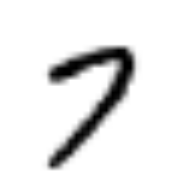

In [63]:
def plot_img(x):
    plt.figure(figsize=(3, 3))
    plt.imshow(x.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.grid(False)
    plt.tick_params(labelbottom=False, labelleft=False)

idx = np.random.randint(0, len(X_data))
plot_img(X_data[idx])
print('Label = ' + str(y_data[idx]))

In [64]:
# We'll use the 3s and 8s.
X3 = X_data[y_data == 3]
X8 = X_data[y_data == 8]
print(X3.shape)
print(X8.shape)
print()

X = np.vstack([X3, X8])
y = np.concatenate([[-1] * len(X3), [1] * len(X8)])
print(X.shape)
print(y.shape)
print()

(6131, 784)
(5851, 784)

(11982, 784)
(11982,)



In [65]:
def preprocessX(X):
    m = np.mean(X, axis=0)
    X = X - m
    norms = np.linalg.norm(X, axis=1)
    mNorm = np.mean(norms)
    X = X / mNorm
    return X

X = preprocessX(X.astype(float))
y = y.astype(float)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.999)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6131, 784)
(5851, 784)

(11982, 784)
(11982,)

(11970, 784)
(11970,)
(12, 784)
(12,)


Label of sample image is -1


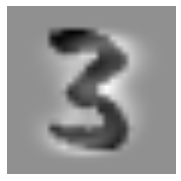

In [67]:
# Sanity check.
sampleImgIdx = np.random.randint(0, len(X_train))
sampleImg = X_train[sampleImgIdx]
sampleLabel = y_train[sampleImgIdx]
print('Label of sample image is ' + str(sampleLabel))
plot_img(sampleImg)

## Next steps
1. Plot eigenvalues as a function of i where i is the ith largest eigenvalue. Do for different $\alpha \in [0, 1]$
1. Plot $d_{95}$ (effective dimension) as a function of $\alpha$.
1. Logistic (or SVM) error as a function of $\alpha$. (note hidden targest are input an label targets). 

Question:
Throw away eigenvalues below some threshold. Not the same as $d_{95}$

## IO function
To help with saving and loading experiments.

In [66]:
from time import time
import os
from os.path import isdir, join
from glob import fnmatch

def filePrefix(alpha):
    '''x is a float.'''
    s = '{0:.12f}'.format(alpha)
    prefix = s.replace('.', '_')
    return 'alpha_' + prefix + '_'


def createSaveDirectory():
    '''Creates a unique directory in data/ based on timestamp.'''
    directoryName = str(int(time()))
    path = join('data', directoryName)
    !mkdir $path
    assert isdir(path), 'Directory does not exist\n{0}'.format(path)
    return path

    
def save(arr, alpha, path, which): 
    '''
    arr: The numpy array to save.
    alpha: The alpha associated with this calculation. See above definition.
    path: the directory to store the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fname = join(path, filePrefix(alpha) + which)
    np.save(fname, arr)
    print('Saved: ' + fname)
  

def load(path, which):
    '''
    path: the directory of the data.
    which: either "eigvals" or "H".
    
    returns an iterator of stored eigvals or H.
    '''
    fnames = fnmatch.filter(os.listdir(path), '*{0}*'.format(which))
    print('Loading: {0}, from {1}'.format(','.join(sorted(fnames)), path))
    for fname in sorted(fnames):
        fullPath = join(path, fname)
        
        yield np.load(fullPath)
        


In [67]:
def computeHiddenTargets(alphas, X, y):
    XG = gram(X)
    YG = np.outer(y, y)

    path = createSaveDirectory()
    print('Saving results in dir: ' + path)
    np.save(join(path, 'alphas'), alphas)
    np.save(join(path, 'X'), X)
    np.save(join(path, 'y'), y)
    for alpha in alphas:
        H, eigvals = hiddenTargets(XG, YG, alpha)
        save(H, alpha, path, 'H')
        save(eigvals, alpha, path, 'eigvals')

alphas = np.array([1e-11, 3e-11, 1e-10, 3e-10, 1e-9, 3e-9])
computeHiddenTargets(alphas, X, y)

Saving results in dir: data/1457076696
Saved: data/1457076696/alpha_0_000000000010_H
Saved: data/1457076696/alpha_0_000000000010_eigvals
Saved: data/1457076696/alpha_0_000000000030_H
Saved: data/1457076696/alpha_0_000000000030_eigvals
Saved: data/1457076696/alpha_0_000000000100_H
Saved: data/1457076696/alpha_0_000000000100_eigvals
Saved: data/1457076696/alpha_0_000000000300_H
Saved: data/1457076696/alpha_0_000000000300_eigvals
Saved: data/1457076696/alpha_0_000000001000_H
Saved: data/1457076696/alpha_0_000000001000_eigvals
Saved: data/1457076696/alpha_0_000000003000_H
Saved: data/1457076696/alpha_0_000000003000_eigvals


In [83]:
experiment_number = 'mnist_1456811360'

Loading: alpha_0_000000000010_eigvals.npy,alpha_0_000000000030_eigvals.npy,alpha_0_000000000100_eigvals.npy,alpha_0_000000000300_eigvals.npy,alpha_0_000000001000_eigvals.npy,alpha_0_000000003000_eigvals.npy,alpha_0_00000001_eigvals.npy,alpha_0_00000003_eigvals.npy,alpha_0_0000001_eigvals.npy,alpha_0_0000003_eigvals.npy,alpha_0_000001_eigvals.npy,alpha_0_000003_eigvals.npy,alpha_0_000010_eigvals.npy,alpha_0_000030_eigvals.npy,alpha_0_000100_eigvals.npy,alpha_0_000300_eigvals.npy,alpha_0_001000_eigvals.npy,alpha_0_003000_eigvals.npy,alpha_0_010000_eigvals.npy,alpha_0_030000_eigvals.npy, from data/mnist_1456811360/


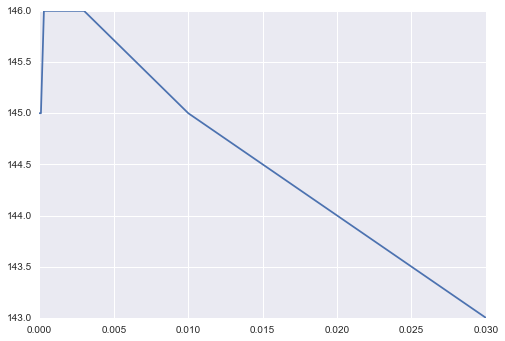

In [86]:
eigvals = load('data/{0}/'.format(experiment_number), which='eigvals')
# alphas = np.arange(0, 1.05, 0.05)
p95 = np.array([effectiveDimension(eigval, p=0.95) for eigval in eigvals])
plt.plot(alphas, p95);


Loading: alpha_0_0000000001_eigvals.npy,alpha_0_0000000003_eigvals.npy,alpha_0_0000000010_eigvals.npy,alpha_0_0000000030_eigvals.npy,alpha_0_0000000100_eigvals.npy,alpha_0_0000000300_eigvals.npy,alpha_0_0000001000_eigvals.npy,alpha_0_0000003000_eigvals.npy,alpha_0_0000010000_eigvals.npy,alpha_0_0000030000_eigvals.npy, from data/1456993244/


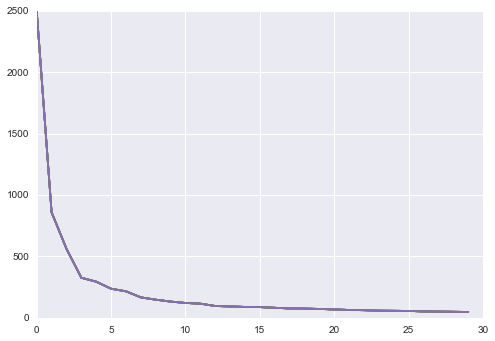

In [18]:
plt.hold(True)
for eigvals in load('data/{0}/'.format(experiment_number), which='eigvals'):
    plt.plot(eigvals[:30])
    
plt.hold(False)

Loading: alpha_0_00000001_eigvals.npy,alpha_0_00000003_eigvals.npy,alpha_0_0000001_eigvals.npy,alpha_0_0000003_eigvals.npy,alpha_0_000001_eigvals.npy,alpha_0_000003_eigvals.npy, from data/1456811360/


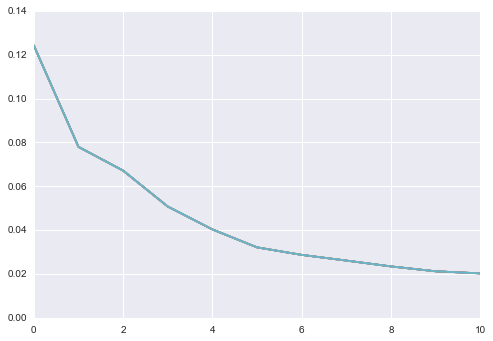

In [51]:
plt.xlim(0, 10)
plt.hold(True)
for eigvals in load('data/{0}/'.format(experiment_number), which='eigvals'):
    plt.plot(eigvals / eigvals.sum())
plt.hold(False);

In [26]:
H, eigvals = hiddenTargets(gram(X), np.outer(y, y), 0)

In [27]:
# On alpha = 0
model = LogisticRegression(C=1e6)
model.fit(H, y)
(model.predict(H) != y).mean()

0.08984533984533985

In [25]:
# On raw training data
model = LogisticRegression(C=1e6)
model.fit(X, y)
(model.predict(X) != y).mean()

0.089743589743589744

In [87]:
from sklearn.linear_model import LogisticRegression

error_train = []
for H in load('data/{0}/'.format(experiment_number), which='H'):
    print(H.shape)
    model = LogisticRegression(C=1e6)
    model.fit(H, y)
    error_train.append((model.predict(H) != y).mean())

Loading: alpha_0_000000000010_H.npy,alpha_0_000000000030_H.npy,alpha_0_000000000100_H.npy,alpha_0_000000000300_H.npy,alpha_0_000000001000_H.npy,alpha_0_000000003000_H.npy,alpha_0_00000001_H.npy,alpha_0_00000003_H.npy,alpha_0_0000001_H.npy,alpha_0_0000003_H.npy,alpha_0_000001_H.npy,alpha_0_000003_H.npy,alpha_0_000010_H.npy,alpha_0_000030_H.npy,alpha_0_000100_H.npy,alpha_0_000300_H.npy,alpha_0_001000_H.npy,alpha_0_003000_H.npy,alpha_0_010000_H.npy,alpha_0_030000_H.npy, from data/mnist_1456811360/
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)
(11982, 613)


Trained logistic regression on (H, y) for different $\alpha$. The following are the error rates.
![asdf](figures/error_alpha_mnist.png)

On a harder training set where we have background images these are the error rates. Base error on raw training set (X, y) was 9%.
![asdf](figures/error_alpha_background.png)


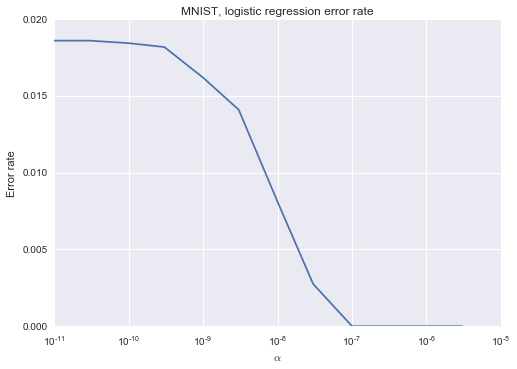

In [90]:
plt.semilogx(alphas[:12], error_train[:12])
plt.xlabel(r'$\alpha$')
plt.ylabel('Error rate')
plt.title('MNIST, logistic regression error rate')
plt.savefig('figures/error_alpha_mnist.png')

Schedule Rob
Mondays: Anytime
Wednesdays: anytime. 
Thursdays: 12:30 - 1:45, 3:30 - 4:45
Fridays: After surfing.

# First attempt at model.
Each layer is affine - relu - affine

Gradient check the layers.

In [126]:
from models.nets import AffineReluAffineNet
from models.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from models.solver import Solver

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [92]:
# This needs to be modified.

from models.layer_utils import affine_relu_affine_forward, affine_relu_affine_backward

x = np.random.randn(2, 3, 4)
w1 = np.random.randn(12, 10)
w2 = np.random.randn(10, 10)
b1 = np.random.randn(10)
b2 = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_affine_forward(x, w1, b1, w2, b2)
dx, dw1, db1, dw2, db2 = affine_relu_affine_backward(dout, cache)

fx = lambda x: affine_relu_affine_forward(x, w1, b1, w2, b2)[0]
fw1 = lambda w1: affine_relu_affine_forward(x, w1, b1, w2, b2)[0]
fb1 = lambda b1: affine_relu_affine_forward(x, w1, b1, w2, b2)[0]
fw2 = lambda w2: affine_relu_affine_forward(x, w1, b1, w2, b2)[0]
fb2 = lambda b2: affine_relu_affine_forward(x, w1, b1, w2, b2)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw1_num = eval_numerical_gradient_array(fw1, w1, dout)
db1_num = eval_numerical_gradient_array(fb1, b1, dout)
dw2_num = eval_numerical_gradient_array(fw2, w2, dout)
db2_num = eval_numerical_gradient_array(fb2, b2, dout)

print ('Testing affine_relu_affine_forward:')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw1 error: ', rel_error(dw1_num, dw1))
print ('db1 error: ', rel_error(db1_num, db1))
print ('dw2 error: ', rel_error(dw2_num, dw2))
print ('db2 error: ', rel_error(db2_num, db2))

ImportError: No module named 'models.layer_utils'

In [93]:
init_scale = 2 / np.sqrt(28*28)
init_scale

0.071428571428571425

In [94]:
model = AffineReluAffineNet(hidden_dims=[30, 30, 30], 
                          input_dim=28*28, 
                          num_classes=10, 
                          reg=0, 
                          weight_scale=init_scale)

loss, grads = model.loss(X_data, y_data)
print(loss)  # Should be around 2.3

2.32091041667


In [137]:
model = AffineReluAffineNet(hidden_dims=[30, 30, 30], 
                          input_dim=28*28, 
                          num_classes=10, 
                          reg=10, 
                          weight_scale=init_scale)


loss, grads = model.loss(X_data, y_data)
print(loss)  

721.671577886


In [140]:
submodel = model[0]

X_r = np.random.rand(100, 28*28)
y_r = 0.1 * np.random.randn(100, 30) - 10
X_rval = np.random.rand(10, 28*28)
y_rval = 0.1 * np.random.randn(10, 30) + 10
l, gr = submodel.loss(X_r, y_r)
print(l)
l, gr = submodel.loss(X_rval, y_rval)
print(l)
data = {'X_train': X_r, 'y_train': y_r, 'X_val': X_rval, 'y_val': y_rval}

1217.11880437
3265.48949562


In [ ]:
solver = Solver(submodel, data, classification=False,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=1000, batch_size=100,
                print_every=100)
solver.train()

(Iteration 1 / 1000) loss: 1218.766400
(Epoch 1 / 1000) train loss: 1159.933445; val_loss: 3390.851256
(Epoch 2 / 1000) train loss: 1106.376679; val_loss: 3517.899100
(Epoch 3 / 1000) train loss: 1056.500476; val_loss: 3645.975878
(Epoch 4 / 1000) train loss: 1010.299417; val_loss: 3774.396125
(Epoch 5 / 1000) train loss: 967.726936; val_loss: 3902.432315
(Epoch 6 / 1000) train loss: 928.689824; val_loss: 4029.388154
(Epoch 7 / 1000) train loss: 893.058712; val_loss: 4154.554071
(Epoch 8 / 1000) train loss: 860.673801; val_loss: 4277.270521
(Epoch 9 / 1000) train loss: 831.352022; val_loss: 4396.857926
(Epoch 10 / 1000) train loss: 804.891401; val_loss: 4512.634139
(Epoch 11 / 1000) train loss: 781.072247; val_loss: 4623.989731
(Epoch 12 / 1000) train loss: 759.667432; val_loss: 4730.449406
(Epoch 13 / 1000) train loss: 740.449569; val_loss: 4831.543815
(Epoch 14 / 1000) train loss: 723.193783; val_loss: 4927.052261
(Epoch 15 / 1000) train loss: 707.690360; val_loss: 5016.733520
(Epoch

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=1000)
data = dict(X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test)

init_scale = 2 / np.sqrt(28*28) 
model = AffineReluAffineNet(hidden_dims=[30, 30, 30], 
                          input_dim=28*28, 
                          num_classes=10, 
                          reg=0, 
                          weight_scale=init_scale)

solver = Solver(model, data,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=30, batch_size=100,
                print_every=100)
solver.train()

(Iteration 1 / 300) loss: 2.301971
(Epoch 0 / 30) train acc: 0.137000; val_acc: 0.138525
(Epoch 1 / 30) train acc: 0.282000; val_acc: 0.262898
(Epoch 2 / 30) train acc: 0.591000; val_acc: 0.554508
(Epoch 3 / 30) train acc: 0.680000; val_acc: 0.631915
(Epoch 4 / 30) train acc: 0.745000; val_acc: 0.703407
(Epoch 5 / 30) train acc: 0.794000; val_acc: 0.744034
(Epoch 6 / 30) train acc: 0.840000; val_acc: 0.779763
(Epoch 7 / 30) train acc: 0.866000; val_acc: 0.797729
(Epoch 8 / 30) train acc: 0.883000; val_acc: 0.793203
(Epoch 9 / 30) train acc: 0.897000; val_acc: 0.820847
(Epoch 10 / 30) train acc: 0.919000; val_acc: 0.823220
(Iteration 101 / 300) loss: 0.395248
(Epoch 11 / 30) train acc: 0.920000; val_acc: 0.826119
(Epoch 12 / 30) train acc: 0.935000; val_acc: 0.831322
(Epoch 13 / 30) train acc: 0.948000; val_acc: 0.835932
(Epoch 14 / 30) train acc: 0.959000; val_acc: 0.843136
(Epoch 15 / 30) train acc: 0.960000; val_acc: 0.846949
(Epoch 16 / 30) train acc: 0.964000; val_acc: 0.842966
(Ep

In [14]:
print(sorted(model.params.keys()))

[(0, 'W1'), (0, 'W2'), (0, 'b1'), (0, 'b2'), (1, 'W1'), (1, 'W2'), (1, 'b1'), (1, 'b2'), (2, 'W1'), (2, 'W2'), (2, 'b1'), (2, 'b2'), (3, 'W'), (3, 'b')]


In [15]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = AffineReluAffineNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30194354405
(0, 'W1') relative error: 6.31e-06
(0, 'W2') relative error: 1.74e-06
(0, 'b1') relative error: 9.31e-08
(0, 'b2') relative error: 1.08e-07
(1, 'W1') relative error: 4.79e-05
(1, 'W2') relative error: 6.55e-06
(1, 'b1') relative error: 2.07e-08
(1, 'b2') relative error: 7.67e-09
(2, 'W') relative error: 1.51e-06
(2, 'b') relative error: 1.21e-10
Running check with reg =  3.14
Initial loss:  12.1133693468
(0, 'W1') relative error: 1.17e-07
(0, 'W2') relative error: 3.22e-08
(0, 'b1') relative error: 2.69e-07
(0, 'b2') relative error: 1.42e-07
(1, 'W1') relative error: 1.61e-08
(1, 'W2') relative error: 1.12e-07
(1, 'b1') relative error: 2.20e-08
(1, 'b2') relative error: 8.56e-08
(2, 'W') relative error: 1.77e-08
(2, 'b') relative error: 3.87e-10


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9)
data = dict(X_train=X_train, X_val=X_test, y_train=y_train, y_val=y_test)

# for it in range(30):
init_scale = 2 / np.sqrt(28*28) 
model = AffineReluAffineNet(hidden_dims=[30, 25, 30], 
                          input_dim=28*28, 
                          num_classes=10, 
                          reg=0, 
                          weight_scale=init_scale)

solver = Solver(model, data,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=30, batch_size=100,
                print_every=100)
solver.train()

(Iteration 1 / 16200) loss: 2.289934
(Epoch 0 / 30) train acc: 0.118000; val_acc: 0.112833
(Iteration 101 / 16200) loss: 0.498059
(Iteration 201 / 16200) loss: 0.355993
(Iteration 301 / 16200) loss: 0.254787
(Iteration 401 / 16200) loss: 0.281160
(Iteration 501 / 16200) loss: 0.175544
(Epoch 1 / 30) train acc: 0.931000; val_acc: 0.931167
(Iteration 601 / 16200) loss: 0.208472
(Iteration 701 / 16200) loss: 0.136653
(Iteration 801 / 16200) loss: 0.222881
(Iteration 901 / 16200) loss: 0.086840
(Iteration 1001 / 16200) loss: 0.254276
(Epoch 2 / 30) train acc: 0.952000; val_acc: 0.945500
(Iteration 1101 / 16200) loss: 0.081361
(Iteration 1201 / 16200) loss: 0.306804
(Iteration 1301 / 16200) loss: 0.160536
(Iteration 1401 / 16200) loss: 0.136419
(Iteration 1501 / 16200) loss: 0.163765
(Iteration 1601 / 16200) loss: 0.164559
(Epoch 3 / 30) train acc: 0.959000; val_acc: 0.954167
(Iteration 1701 / 16200) loss: 0.175701
(Iteration 1801 / 16200) loss: 0.199718
(Iteration 1901 / 16200) loss: 0.107

In [33]:
submodel = model[0:3]